# Heralded CNOT
This notebook demonstrates the operation of the Heralded CNOT gate from <cite data-cite="KLM2001">(KLM2001)</cite>.

In [1]:
import numpy as np

import lightworks as lw
from lightworks import State, emulator

## Layout
The CNOT is built from a set of known phase settings below. These settings require the beam splitter to be in the "H" convention

In [2]:
# Set required element reflectivity
n1 = 2 * np.arccos(1 / (4 - 2 * 2**0.5) ** 0.5)
n2 = 2 * np.arccos(2**0.5 - 1)

cnot_circuit = lw.PhotonicCircuit(8)

# Loop over required elements, the format here is:
# (mode, [bs reflectivity, phase 1, phase 2])
data = [
    (0, [n1, np.pi, np.pi]),
    (4, [np.pi / 2, 0, 0]),
    (6, [n1, 0, 0]),
    (1, [np.pi, 0, 0]),
    (3, [np.pi / 2, 0, 0]),
    (5, [np.pi, 0, 0]),
    (2, [n2, 0, 0]),
    (4, [n2, np.pi, np.pi]),
    (1, [np.pi, 0, 0]),
    (3, [np.pi / 2, 0, 0]),
    (5, [np.pi, 0, 0]),
    (0, [n1, np.pi, np.pi]),
    (4, [np.pi / 2, 0, 0]),
    (6, [n1, 0, 0]),
]

# Loop over each element and add
for mode, d in data:
    theta, phi1, phi2 = d
    if phi1 > 0:
        cnot_circuit.ps(mode + 1, phi1)
    cnot_circuit.bs(mode, reflectivity=np.cos(theta / 2) ** 2, convention="H")
    if phi2 > 0:
        cnot_circuit.ps(mode, phi2)

# Add the required heralds to the circuit on the ancillary modes.
cnot_circuit.herald(0, 0)
cnot_circuit.herald(1, 1)
cnot_circuit.herald(1, 6)
cnot_circuit.herald(0, 7)

Once created, the circuit can be viewed with labelled modes. The c and t mode are the control and target qubit modes respectively, and the a and b modes are the ancillary modes required for implementation of the gate. The heralded modes can also be seen here. 

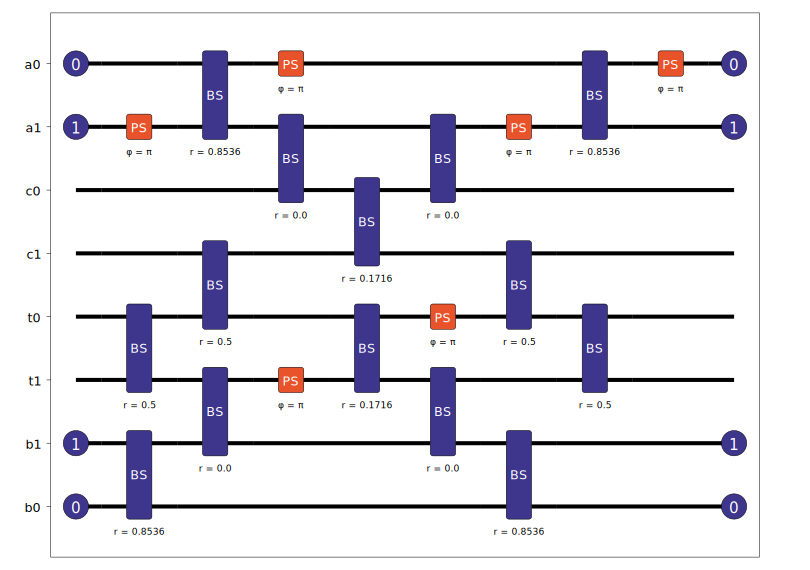

In [3]:
cnot_circuit.display(
    mode_labels=["a0", "a1", "c0", "c1", "t0", "t1", "b1", "b0"]
)

## Sampling
Once created, the circuit is then simulated with the Sampler.

.. note:: This cell can take quite a while to run (~30 seconds).

In [4]:
# Set qubit input here
in_qubits = "10"

# This is then converted into modes
c, t = in_qubits
c, t = int(c), int(t)
in_state = State([1 - c, c, 1 - t, t])

# Run sampler with imperfect properties
source = emulator.Source(indistinguishability=0.93, purity=0.98)
detector = emulator.Detector(photon_counting=False)

# Apply heralding rules and sample
N_rep = 10000
sampler = lw.Sampler(
    cnot_circuit,
    in_state,
    N_rep,
    source=source,
    detector=detector,
    min_detection=2,
    random_seed=7,
)

backend = emulator.Backend("slos")
results = backend.run(sampler)

Once results are collected, it can be seen that in the case of a $\ket{10}$ input, the most likely output is $\ket{11}$ (|0,1,0,1> in mode language), as expected.

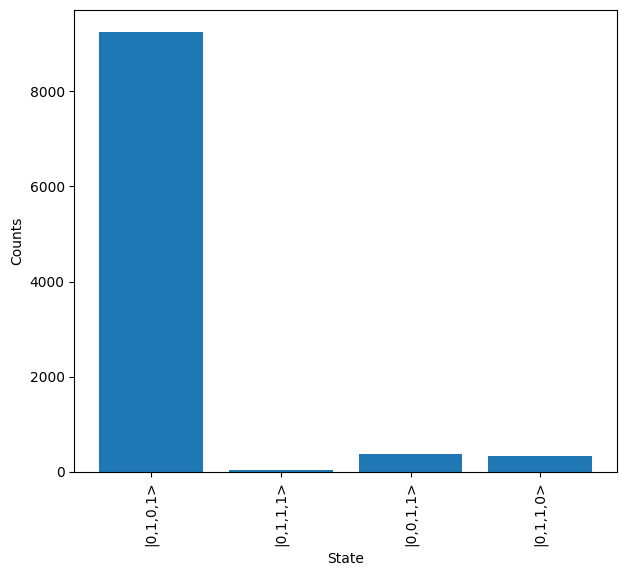

In [5]:
results.plot(show=True)